# Importación de librerias necesarias

In [1]:
import os
import random

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import imghdr

In [380]:
### Avoid OOM Errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Remover imagenes no útiles
Asegurarse que todas las imagenes tengan el formato adecuado

In [381]:
DATA_DIR = os.path.abspath('data')
DATA_DIR

'C:\\Users\\Fran\\git\\vetlens-ml\\data'

In [382]:
IMAGE_EXTS = ['jpeg', 'jpg', 'bmp', 'png']
for image_class in os.listdir(DATA_DIR):
    for image in os.listdir(os.path.join(DATA_DIR, image_class)):
        image_path = os.path.join(DATA_DIR, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)

            if tip not in IMAGE_EXTS:
                print(f'Image has ext: {tip} not in ext list {image_path}')
                #os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

# Visualización de los datos con los que se está trabajando

In [384]:
class_names = []
img_count = np.array([])
for class_name in os.listdir(os.path.join(DATA_DIR)):
    count = len(os.listdir(os.path.join(DATA_DIR, class_name)))
    class_names.append(class_name)
    img_count = np.append(img_count, count)
class_names,img_count

(['dermatitis_piotraumatica',
  'dermatofitosis',
  'miasis',
  'otra_enfermedad',
  'sin_problemas'],
 array([48., 48., 46., 42., 49.]))

In [385]:
print(f'Mediana de imagenes por clase: {np.median(img_count)}')

Mediana de imagenes por clase: 48.0


Comprobamos que el dataset esta balanceado:

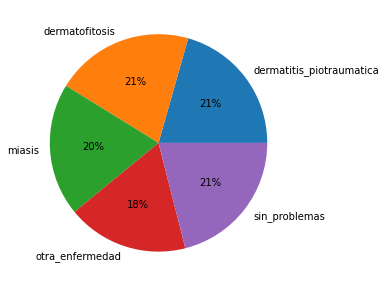

In [386]:
fig = plt.figure(figsize=(5,5))
pie = plt.pie(img_count, labels=class_names, autopct= lambda x: '{:.0f}%'.format(x))
plt.show()

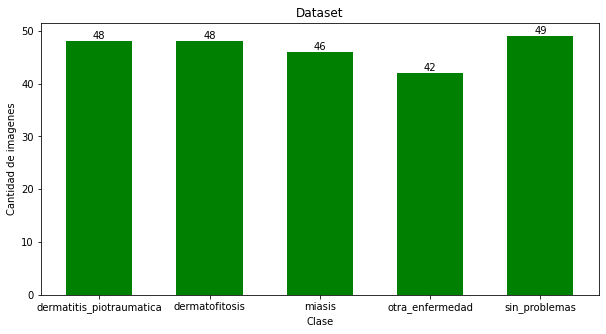

In [387]:
fig = plt.figure(figsize= (10,5))
bars = plt.bar(class_names, img_count, color='green', width=.6)
plt.bar_label(bars)
plt.ylabel('Cantidad de imagenes')
plt.xlabel('Clase')
plt.title('Dataset')
plt.show()

# Aumento de Datos
Dado que el dataset inicial es bastante pequeño, realizaremos operaciones de aumento de datos. De esta forma, se aumenta la cantidad de datos para entrenamiento, prueba y validación y también se disminuye la probabilidad de overfitting.

Primero definimos las transformaciones:

In [388]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    zoom_range=.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)

In [389]:
def augment (x, dir, prefix):
    i = 0
    for batch in datagen.flow(x, batch_size=32, save_to_dir=dir, save_prefix=prefix, save_format='jpeg'):
        i +=1
        if i > 20: # paramos la cantidad de transformaciones para evitar que sean infinitas
            break

In [390]:
def process_image(image_path, img_size=224):

  """
  Toma la ruta de una imagen y la devuelve como un Tensor
  """

  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

In [392]:
derm_dir = [os.path.abspath(os.path.join('data','dermatofitosis', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','dermatofitosis')))]
pio_dir = [os.path.abspath(os.path.join('data','dermatitis_piotraumatica', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','dermatitis_piotraumatica')))]
mia_dir = [os.path.abspath(os.path.join('data','miasis', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','miasis')))]
sin_prob_dir = [os.path.abspath(os.path.join('data','sin_problemas', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','sin_problemas')))]
otras_dir = [os.path.abspath(os.path.join('data','otra_enfermedad', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','otra_enfermedad')))]


derm_dir, pio_dir, mia_dir, otras_dir

(['C:\\Users\\Fran\\git\\vetlens-ml\\data\\dermatofitosis\\1727490895.jpg',
  'C:\\Users\\Fran\\git\\vetlens-ml\\data\\dermatofitosis\\3_hongos_7531_3_orig.jpg',
  'C:\\Users\\Fran\\git\\vetlens-ml\\data\\dermatofitosis\\481952420.jpg',
  'C:\\Users\\Fran\\git\\vetlens-ml\\data\\dermatofitosis\\5c77f1414ef581ab8e6a82d4_Te7yYtPMLQzYvvbjvj7r4YTReAUPc4vXRtWXwIixqXUz-Qdv47wWN5Wjoi0FrW2lu-g-prH6B4g2s3DDtHHiTTmJC949HcoJAZpWKrKXA-QszLIxryhROGG-gHCKtsLO4R0gGOU5.jpg',
  'C:\\Users\\Fran\\git\\vetlens-ml\\data\\dermatofitosis\\cancerpiel.jpg',
  'C:\\Users\\Fran\\git\\vetlens-ml\\data\\dermatofitosis\\d5d8b6_5cf05e9681b84e969dc8cc24a658edf2~mv2.jpg',
  'C:\\Users\\Fran\\git\\vetlens-ml\\data\\dermatofitosis\\d5d8b6_e182bd76391e4990880be1f616c3dedd~mv2.jpg',
  'C:\\Users\\Fran\\git\\vetlens-ml\\data\\dermatofitosis\\dermatophytosis-in-a-dog-primary-ca-en.jpg__585.0x348.0_q80_su123bsampling-2.jpg',
  'C:\\Users\\Fran\\git\\vetlens-ml\\data\\dermatofitosis\\dermatophytosis-in-a-dog-primary-ca-en.jp

In [394]:
derm = tf.data.Dataset.from_tensor_slices(tf.constant(derm_dir))
derm_batch = derm.map(process_image).batch(32)
pio = tf.data.Dataset.from_tensor_slices(tf.constant(pio_dir))
pio_batch = pio.map(process_image).batch(32)
mia = tf.data.Dataset.from_tensor_slices(tf.constant(mia_dir))
mia_batch = mia.map(process_image).batch(32)
sin_prob = tf.data.Dataset.from_tensor_slices(tf.constant(sin_prob_dir))
sin_prob_batch = sin_prob.map(process_image).batch(32)
otra = tf.data.Dataset.from_tensor_slices(tf.constant(otras_dir))
otra_batch = otra.map(process_image).batch(32)

derm_batch, pio_batch, mia_batch

(<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>,
 <BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>,
 <BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>)

In [395]:
for img in derm_batch.as_numpy_iterator():
    augment(img, 'data\\dermatofitosis', 'dermatofitosis')
for img in pio_batch.as_numpy_iterator():
    augment(img, 'data\\dermatitis_piotraumatica', 'piotraumatica')
for img in mia_batch.as_numpy_iterator():
    augment(img, 'data\\miasis', 'miasis')
for img in sin_prob_batch.as_numpy_iterator():
    augment(img, 'data\\sin_problemas', 'sin_problemas')
for img in otra_batch.as_numpy_iterator():
    augment(img, 'data\\otra_enfermedad', 'otra_enfermedad')

# Comenzamos a trabajar con los datos

In [409]:
IMAGE_SIZE = 224
INPUT_SHAPE = (None, IMAGE_SIZE, IMAGE_SIZE, 3)
SEED = random.randint(0,10000000)
SEED

850574

In [410]:
training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    label_mode='categorical',
    color_mode='rgb',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    shuffle=True,
    seed=SEED,
    validation_split=.2,
    subset='both',
    interpolation='bicubic')

Found 5122 files belonging to 5 classes.
Using 4098 files for training.
Using 1024 files for validation.


In [411]:
training_dataset, validation_dataset

(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

In [412]:
diseases = training_dataset.class_names

In [413]:
batch_train = training_dataset.as_numpy_iterator().next()
batch_val = validation_dataset.as_numpy_iterator().next()

In [414]:
def print_first_10(batch, has_labels=True):
    """
    Imprime las primeras 10 imagenes de un batch de imagenes, y si poseen labels, las labels respectivas
    :param batch: a batch of images
    :return: None
    """
    fig, ax = plt.subplots(ncols=10, figsize=(20,20))
    for idx, img in enumerate(batch[0][:10]):
        ax[idx].imshow(img.astype(int))
        if has_labels:
            ax[idx].title.set_text(diseases[np.argmax(batch[1][idx])])

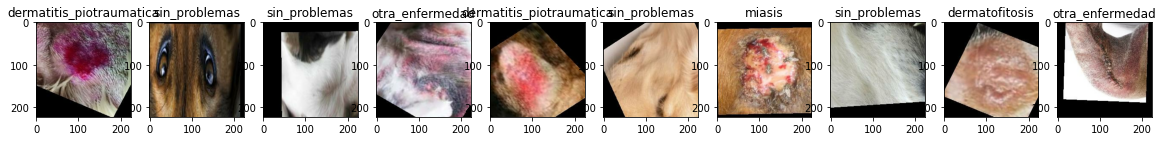

In [415]:
print_first_10(batch_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


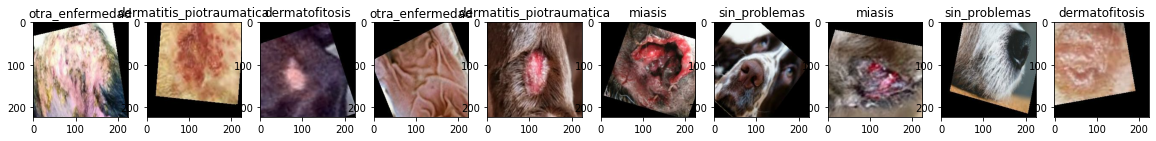

In [416]:
print_first_10(batch_val)

Debemos normalizar las imágenes, es decir, transformar los valores de los pixeles que van de 0 - 255, para que vayan de 0 - 1:

In [417]:
training_dataset = training_dataset.map(lambda x, y: (x/255, y))
validation_dataset = validation_dataset.map(lambda x, y: (x/255, y))
training_dataset, validation_dataset

(<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

# Construcción del Modelo

Utilizaremos transfer learning, dado que el dataset disponible actualmente es pequeño. Para ello usaremos como base el modelo VGG-16 entrenado con ImageNet. Luego agregaremos dos capas una de Flatten y una Dense.

In [424]:
base_model = tf.keras.applications.Xception(include_top=False,
                                            weights='imagenet',
                                            input_shape=(224, 224 ,3))
base_model.trainable = False

model = tf.keras.Sequential()

model.add(base_model)

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(5, activation='softmax'))


In [425]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_16 (Flatten)        (None, 100352)            0         
                                                                 
 dense_21 (Dense)            (None, 5)                 501765    
                                                                 
Total params: 21,363,245
Trainable params: 501,765
Non-trainable params: 20,861,480
_________________________________________________________________


In [426]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Entrenamiento del Modelo

In [427]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Definimos early_stopping para evitar que el modelo haga overfitting:

In [428]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [429]:
hist = model.fit(training_dataset, epochs=50, validation_data=validation_dataset, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/50
129/129 [==============================] - 24s 164ms/step - loss: 1.2050 - accuracy: 0.5142 - val_loss: 0.9417 - val_accuracy: 0.6670
Epoch 2/50
129/129 [==============================] - 20s 153ms/step - loss: 0.7934 - accuracy: 0.7369 - val_loss: 0.7416 - val_accuracy: 0.7461
Epoch 3/50
129/129 [==============================] - 20s 154ms/step - loss: 0.6280 - accuracy: 0.8106 - val_loss: 0.6360 - val_accuracy: 0.7959
Epoch 4/50
129/129 [==============================] - 20s 155ms/step - loss: 0.5232 - accuracy: 0.8565 - val_loss: 0.5652 - val_accuracy: 0.8232
Epoch 5/50
129/129 [==============================] - 20s 155ms/step - loss: 0.4493 - accuracy: 0.8851 - val_loss: 0.5104 - val_accuracy: 0.8555
Epoch 6/50
129/129 [==============================] - 20s 156ms/step - loss: 0.3930 - accuracy: 0.9061 - val_loss: 0.4721 - val_accuracy: 0.8662
Epoch 7/50
129/129 [==============================] - 20s 154ms/step - loss: 0.3482 - accuracy: 0.9217 - val_loss: 0.4422 - val_ac

# Métricas del modelo

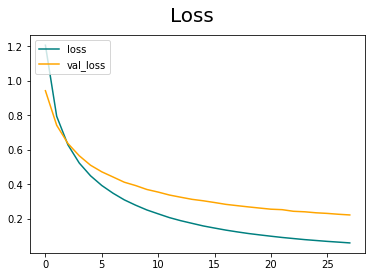

In [430]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

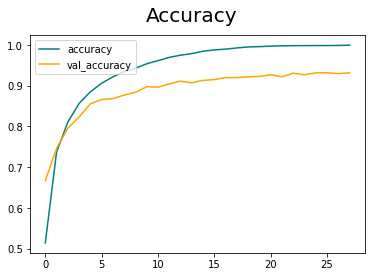

In [431]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# Predicciones

In [432]:
prediction = model.predict(validation_dataset)

32/32 [==============================] - 5s 121ms/step


In [433]:
prediction

array([[3.3673984e-01, 3.3109376e-04, 2.6041582e-02, 6.3353384e-01,
        3.3536784e-03],
       [4.9462497e-01, 3.4013981e-01, 1.2246230e-01, 3.1383950e-02,
        1.1388938e-02],
       [1.3141226e-02, 9.4129688e-01, 1.5961809e-02, 1.0084940e-02,
        1.9515099e-02],
       ...,
       [1.7716413e-03, 8.4705544e-01, 1.3783808e-01, 1.2518968e-02,
        8.1577949e-04],
       [9.7652122e-02, 7.1940351e-01, 3.1725924e-02, 1.0172249e-01,
        4.9496084e-02],
       [9.2884656e-03, 3.6976822e-02, 5.4291032e-02, 8.2421213e-01,
        7.5231552e-02]], dtype=float32)

In [434]:
images = []
labels = []
for image, label in validation_dataset.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(diseases[np.argmax(label)])

images[0], labels[0]

(array([[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        ...,
 
        [[0.        , 0.00392157, 0.00784314],
         [0.        , 0.00392157, 0.00784

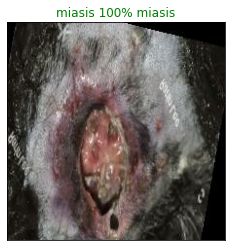

In [435]:
def plot_pred(prediction_probabilities, labels_p, images_p, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image_v = prediction_probabilities[n], labels_p[n], images_p[n]
  # Get the pred label
  pred_label = diseases[np.argmax(pred_prob)]

  # Plot image and remove ticks
  plt.imshow(image_v)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong.

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change the plot title to be predicted label, probability of prediction and truth label.
  plt.title("{} {:2.0f}% {}".format(pred_label, np.max(pred_prob)*100, true_label), color=color)
plot_pred(prediction, labels, images, n=36)

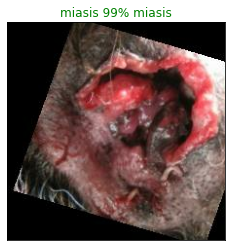

In [436]:
plot_pred(prediction, labels, images, n=5)

In [437]:
def plot_pred_conf(prediction_probabilities, labels_x, n=1):
  """
  Plot the top 10 highest prediction confidences along with the truth label for sample n
  """
  pred_prob, true_label = prediction_probabilities[n], labels_x[n]

  # Get the predicted label

  pred_label = diseases[np.argmax(pred_prob)]

  # Find the top 10 prediction confidence indexes

  top_3_pred_indexes = pred_prob.argsort()# En orden descendente
  # Find the top 10 prediction confidence values
  top_3_pred_values = pred_prob[top_3_pred_indexes]

  # Find the top 10 prediction labels

  top_3_pred_labels = np.array(diseases)[top_3_pred_indexes]

  # Setup plot

  top_plot = plt.bar(np.arange(len(top_3_pred_labels)), top_3_pred_values, color="grey")
  plt.xticks(np.arange(len(top_3_pred_labels)), labels=top_3_pred_labels, rotation="vertical")

  # Change color of the true label

  if np.isin(true_label, top_3_pred_indexes):
    top_plot[np.argmax(top_3_pred_indexes == true_label)].set_color("green")
  else:
    pass

C:\Users\Fran\.conda\envs\tf\lib\site-packages\numpy\lib\arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


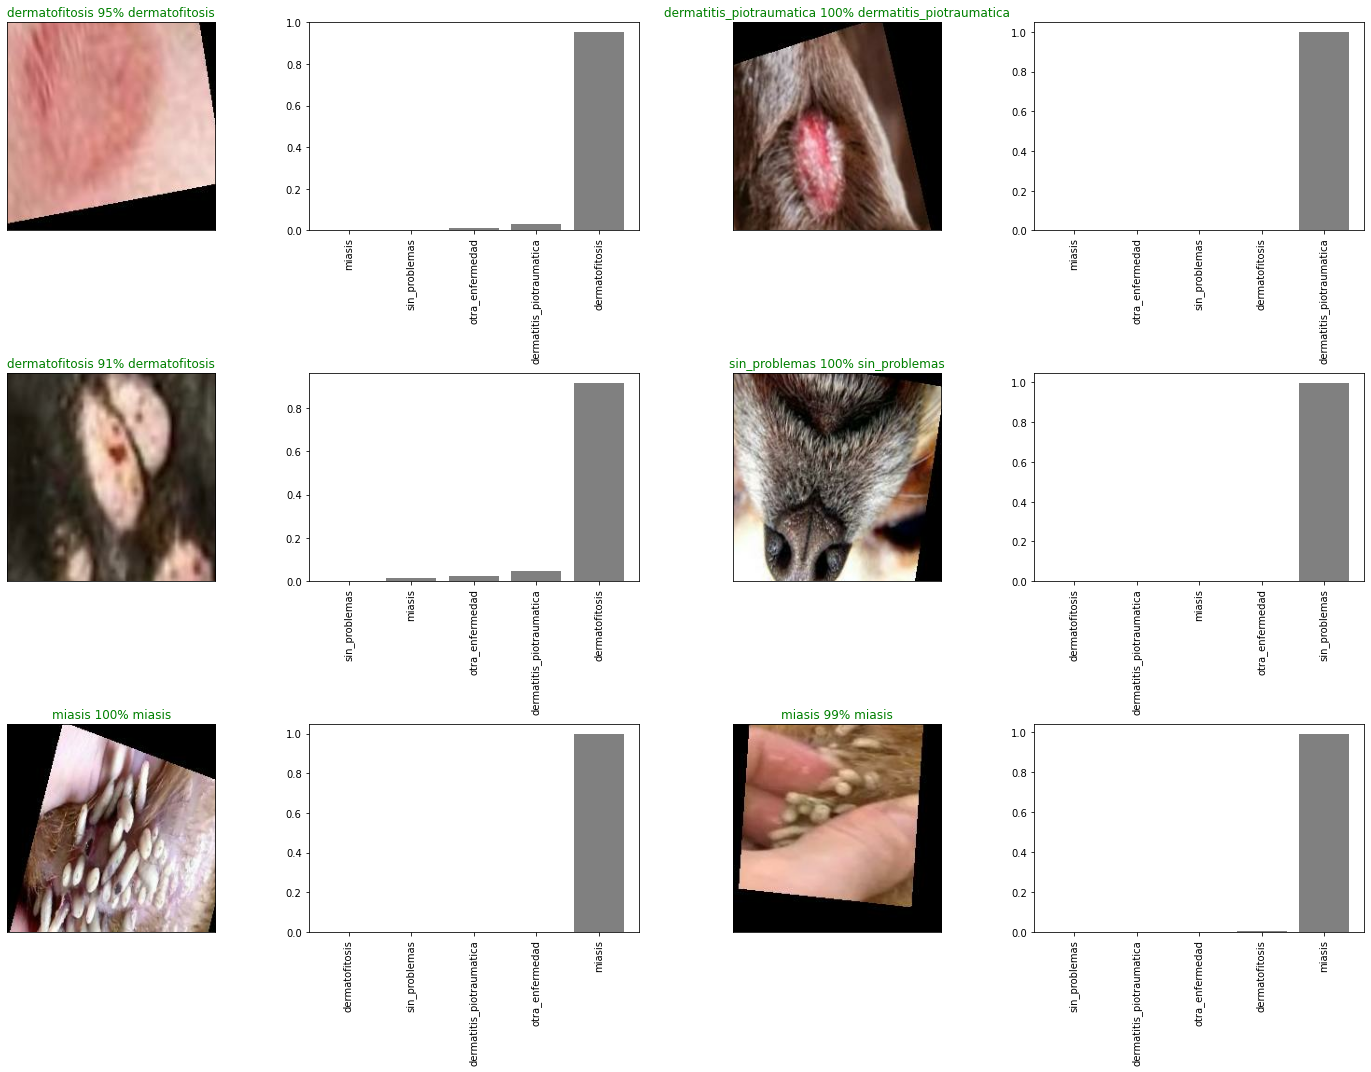

In [438]:
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range (num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=prediction, labels_p=labels, images_p=images, n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction, labels, n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [443]:
def get_test_img_paths_with_labels(testing_dir='testing'):
    test_img_paths = []
    test_labels = []

    for folder_name in os.listdir(testing_dir):
        for file_name in os.listdir(os.path.join(testing_dir, folder_name)):
            test_img_paths.append(os.path.abspath(os.path.join(testing_dir, folder_name, file_name)))
            test_labels.append(folder_name)

    return test_img_paths, test_labels

In [451]:
def make_prediction(images_paths, model_to_use='trained'):
    dataset = tf.data.Dataset.from_tensor_slices(tf.constant(images_paths))
    dataset_batch = dataset.map(process_image).batch(32)
    if model_to_use == 'xception':
        ## 4 clases
        xception_model = tf.keras.models.load_model((os.path.join('models', 'dogsskindiseaseswithother_v1_xception.h5')))
        predictions = xception_model.predict(dataset_batch)
    elif model_to_use == 'vgg16':
        ## 3 clases
        vgg16_model = tf.keras.models.load_model((os.path.join('models', 'dogsskindiseaseswithother_v1.h5')))
        predictions = vgg16_model.predict(dataset_batch)
    elif model_to_use == 'trained':
        predictions = model.predict(dataset_batch)
    else:
        print('There is no such model!')
        return
    return predictions

In [462]:
def print_text_pred_5_classes(predictions, test_image_paths, test_lbls):
    accurate_pred = 0
    total_pred = len(test_image_paths)
    file_names = [fname.split('\\')[-1] for fname in test_image_paths]

    for idx, img in enumerate(file_names):
        pred_res = diseases[np.argmax(predictions[idx])]
        if pred_res == test_lbls[idx] or pred_res == 'sin_problemas' and test_lbls[idx] == 'otra_enfermedad' or pred_res == 'otra_enfermedad' and test_lbls[idx] == 'sin_problemas':
            accurate_pred += 1
        print(f'Prediction for image: {img} is \'{diseases[np.argmax(predictions[idx])]}\' with a {predictions[idx][np.argmax(predictions[idx])]*100:.2f}%. True class: {test_lbls[idx]}.\nResults: \'dermatofitosis\': {predictions[idx][1]*100:.2f}%, \'piotraumatica\': {predictions[idx][0]*100:.2f}%, \'miasis\': {predictions[idx][2]*100:.2f}%, \'otras\': {predictions[idx][3]*100:.2f}%, \'sano\': {predictions[idx][4]*100:.2f}%\n=====================================')
    print(f'Precision: {(accurate_pred/total_pred)*100}')

In [458]:
def print_text_pred_4_classes(predictions, test_image_paths, test_lbls):
    accurate_pred = 0
    total_pred = len(test_image_paths)
    file_names = [fname.split('\\')[-1] for fname in test_image_paths]

    for idx, img in enumerate(file_names):
        pred_res = diseases[np.argmax(predictions[idx])]
        if pred_res == test_lbls[idx] or pred_res == 'otra_enfermedad' and test_lbls[idx] == 'sin_problemas':
            accurate_pred += 1
        print(f'Prediction for image: {img} is \'{diseases[np.argmax(predictions[idx])]}\' with a {predictions[idx][np.argmax(predictions[idx])]*100:.2f}%. True class: {test_lbls[idx]}.\nResults: \'dermatofitosis\': {predictions[idx][1]*100:.2f}%, \'piotraumatica\': {predictions[idx][0]*100:.2f}%, \'miasis\': {predictions[idx][2]*100:.2f}%, \'otras\': {predictions[idx][3]*100:.2f}%\n=====================================')
    print(f'Precision: {(accurate_pred/total_pred)*100}')

In [461]:
test_img_paths, test_labels = get_test_img_paths_with_labels(testing_dir='testing')
predictions_xception = make_prediction(test_img_paths, model_to_use='xception')
predictions_trained = make_prediction(test_img_paths, model_to_use='trained')

2/2 [==============================] - 0s 119ms/step
Prediction for image: dermatitis piotraumatica_0.jpg is 'dermatitis_piotraumatica' with a 73.95%. True class: dermatitis_piotraumatica.
Results: 'dermatofitosis': 8.93%, 'piotraumatica': 73.95%, 'miasis': 0.35%, 'otras': 16.76%
Prediction for image: dermatitis piotraumatica_1.jpg is 'dermatofitosis' with a 65.84%. True class: dermatitis_piotraumatica.
Results: 'dermatofitosis': 65.84%, 'piotraumatica': 33.86%, 'miasis': 0.10%, 'otras': 0.20%
Prediction for image: dermatitis piotraumatica_2.jpg is 'dermatitis_piotraumatica' with a 85.28%. True class: dermatitis_piotraumatica.
Results: 'dermatofitosis': 14.69%, 'piotraumatica': 85.28%, 'miasis': 0.01%, 'otras': 0.02%
Prediction for image: dermatitis piotraumatica_3.jpg is 'miasis' with a 57.74%. True class: dermatitis_piotraumatica.
Results: 'dermatofitosis': 0.92%, 'piotraumatica': 37.89%, 'miasis': 57.74%, 'otras': 3.45%
Prediction for image: dermatitis piotraumatica_4.jpg is 'otra_e

In [463]:
print_text_pred_4_classes(predictions_xception, test_image_paths=test_img_paths, test_lbls=test_labels)
print_text_pred_5_classes(predictions_trained, test_image_paths=test_img_paths, test_lbls=test_labels)

Prediction for image: dermatitis piotraumatica_0.jpg is 'dermatitis_piotraumatica' with a 73.95%. True class: dermatitis_piotraumatica.
Results: 'dermatofitosis': 8.93%, 'piotraumatica': 73.95%, 'miasis': 0.35%, 'otras': 16.76%
Prediction for image: dermatitis piotraumatica_1.jpg is 'dermatofitosis' with a 65.84%. True class: dermatitis_piotraumatica.
Results: 'dermatofitosis': 65.84%, 'piotraumatica': 33.86%, 'miasis': 0.10%, 'otras': 0.20%
Prediction for image: dermatitis piotraumatica_2.jpg is 'dermatitis_piotraumatica' with a 85.28%. True class: dermatitis_piotraumatica.
Results: 'dermatofitosis': 14.69%, 'piotraumatica': 85.28%, 'miasis': 0.01%, 'otras': 0.02%
Prediction for image: dermatitis piotraumatica_3.jpg is 'miasis' with a 57.74%. True class: dermatitis_piotraumatica.
Results: 'dermatofitosis': 0.92%, 'piotraumatica': 37.89%, 'miasis': 57.74%, 'otras': 3.45%
Prediction for image: dermatitis piotraumatica_4.jpg is 'otra_enfermedad' with a 53.24%. True class: dermatitis_piot

In [460]:
model.save(os.path.join('models', 'dogsskindiseaseswithother_v2_xception_5_clases.h5'))